# Contando Palavras
Neste capítulo iremos começar a interagir com os textos no nível da linguagem, por meio das ferramentas do Processamento de Linguagem Natural (PLN). Vamos progredir gradualmente nossa representação da linguagem a partir da morfologia, passando pela sintaxe e chegando à semântica. 

Nesta etapa, faremos uso de biliotecas especializadas em PLN como o [NLTK](https://www.nltk.org/) e a [Spacy](https://spacy.io/). 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import nltk
import spacy
import numpy as np
from collections import Counter
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

Bibliotecas de PLN requerem o carregamento de modelos de liguagem para funcionar de maneira apropriada: para este capitulo iremos carregar os modelos específicos da lingua portuguesa. Para isso precisamos executar comandos no terminal do sistema operacional:

In [ ]:
# Descomente a linha abaixo para instalar o modelo para a língua portuguesa, caso ainda não o tenha feito.
# !python3 -m spacy download pt_core_news_sm

Para contar as palavras de um texto, é preciso primeiro separá-las uma a uma. A este processo dá-se o nome de tokenização, e é típicamente fácil de fazer mal-feito e difícil de fazer bem-feito.

Primeiramente precisaremos carregar os verbetes com a função que criamos no capítulo 1.

In [9]:
import glob, os
caminho = "../dhbb/text/*.text"
arquivos  = glob.glob(caminho)

def tabula_verbete(n=None):
    """
    Carrega todos os verbetes disponíveis, ou os primeiros n.
    n:  número de verbetes a tabular
    """
    if n is None:
        n = len(arquivos)
    linhas = []
    for a in arquivos[:n]:
        with open (a, 'r', encoding='utf8') as f:
            verbete = f.read()
        cabeçalho = verbete.split('---')[1]
        campos = {l.split(':')[0].strip() :l.split(':')[1].strip() for l in cabeçalho.split('\n')[:4] if l}
        campos['arquivo'] = os.path.split(a)[1]
        campos['cargos'] = np.nan if 'cargos:' not in cabeçalho else cabeçalho.split('cargos:')[1]
        campos['corpo'] = verbete.split('---')[2]
        linhas.append(campos)
    tabela = pd.DataFrame(data = linhas, columns=['arquivo','title', 'natureza', 'sexo', 'cargos', 'corpo'])
    return tabela

## Lendo os verbetes do Banco de Dados

In [10]:
tabela = tabula_verbete()

In [12]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
#dhbb = pd.read_sql_table('resultados')
biograficos = pd.read_sql_query('select * from resultados where natureza="biográfico"', con=eng)
biograficos.head()

,index,arquivo,title,natureza,sexo,cargos,corpo
0,0,4736.text,"RUBIM, Floriano",biográfico,m,\n - militar\n - dep. fed. ES 1955-1959\n - d...,\n\n«Floriano Lopes Rubim» nasceu em Alegre (E...
1,1,1376.text,"COELHO, Inocêncio Mártires",biográfico,m,\n - proc. ger. Rep. 1981-1985\nautor: \n - L...,\n\n«Inocêncio Mártires Coelho» nasceu em Belé...
2,2,732.text,"BOPP, Raul",biográfico,m,\n - diplomata\n - emb. Bras. Peru 1962-1963\n,\n\n«Raul Bopp» nasceu em Santa Maria (RS) no ...
3,3,2669.text,"KRÜGER, Nivaldo",biográfico,m,\n - dep. fed. PR 1979-1983\n - sen. PR 2002-...,\n\n«Nivaldo Passos Krüger» nasceu em Canoinha...
4,5,3752.text,"NASCIMENTO, César",biográfico,m,\n - dep. fed. SC 1973-1975\n - dep. fed. SC ...,\n\n«César Correia do Nascimento» nasceu em La...


## Tokenização com o NLTK

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/fccoelho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
palavras = nltk.word_tokenize(biograficos.corpo[0])
palavras[:10]

['«', 'Floriano', 'Lopes', 'Rubim', '»', 'nasceu', 'em', 'Alegre', '(', 'ES']

Uma vez "tokenizado" o texto, podemos contar as palavras muito simplesmente usando a função `Counter`do Python

In [15]:
c = Counter(palavras)
c.most_common(n=10)

[(',', 40),
 ('de', 39),
 ('.', 24),
 ('do', 18),
 ('a', 14),
 ('(', 13),
 (')', 13),
 ('em', 12),
 ('da', 12),
 ('e', 11)]

Outra maneira de fazer isso seria usando o NLTK. Com a vantagem de ainda podermos visualizar graficamente.

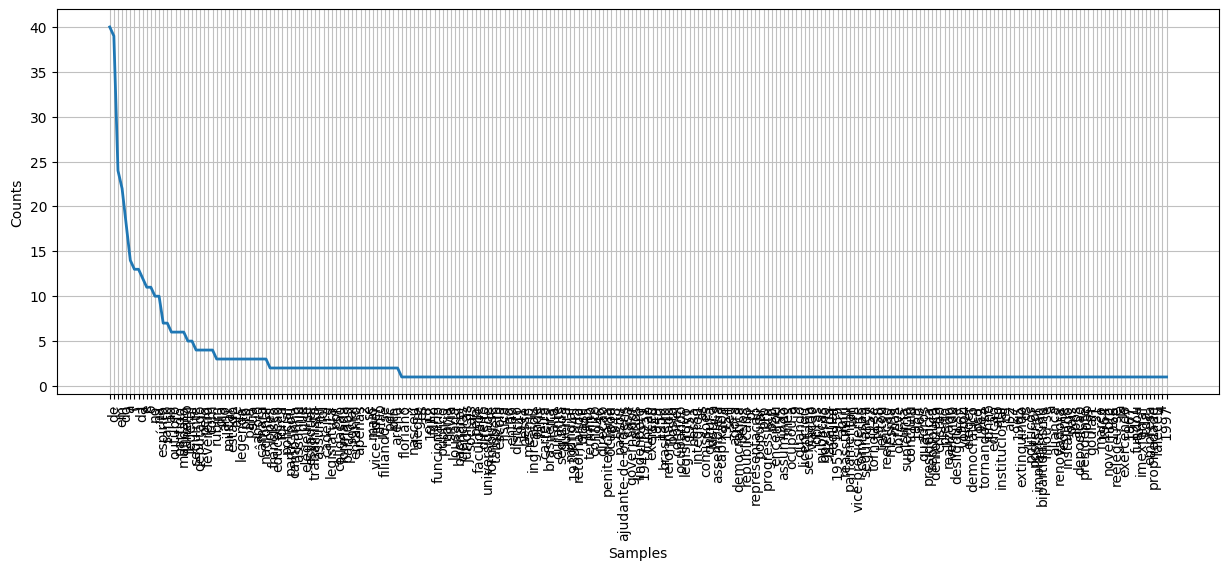

In [19]:
plt.figure(figsize=(15,5))
fd = nltk.FreqDist([p.lower() for p in palavras])
fd.plot();

In [20]:
print("Numero de tokens:", len(palavras))
print("Tamanho do Vocabulário:", len(set([p.lower() for p in palavras])))

Numero de tokens: 595
Tamanho do Vocabulário: 258


Como vemos no exemplo acima, as palavras mais frequentes não muito informativas. Muitas vezes pode ser útil removê-las da análise. Linguistas costumams chamar este tipo de palavras de **stop-words**. Alem disso, vamos tambem remover as pontuaçoes. 

### Removendo as Stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fccoelho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Vamos juntar as stopwords e a pontuação em uma única lista:

In [22]:
sw = nltk.corpus.stopwords.words('portuguese')
from string import punctuation
print(punctuation)
sw[:10]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

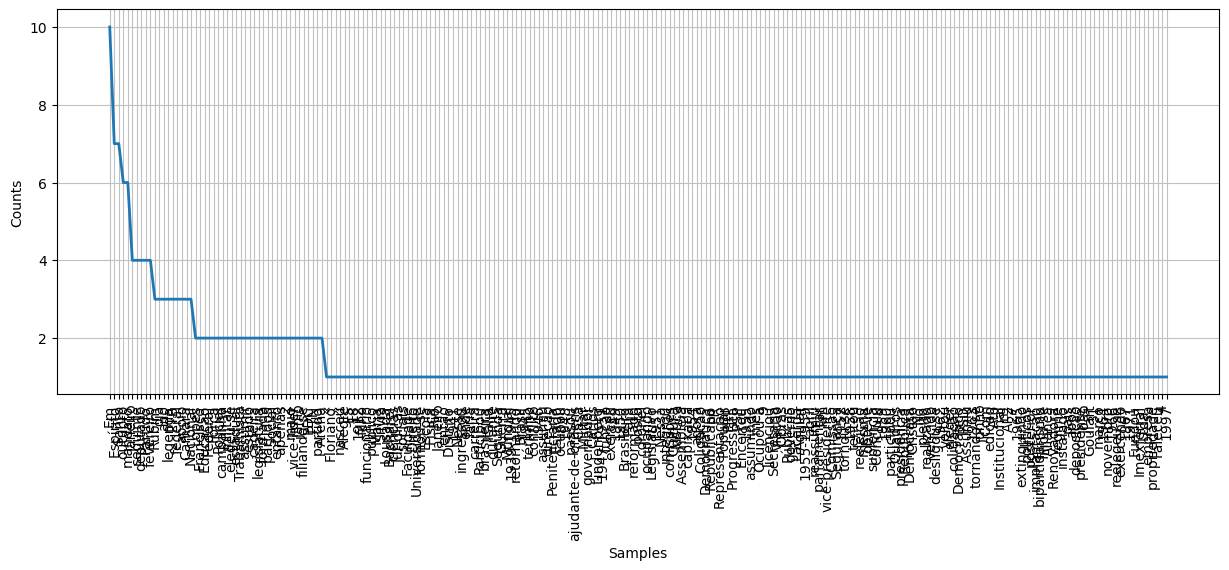

In [23]:
plt.figure(figsize=(15,5))
fd = nltk.FreqDist([p for p in palavras if p not in sw+list(punctuation)])
fd.plot();

# Analizando coleções de textos
Acima analizamos o conteúdo de apenas um verbete, mas seria bem mais relevante podermos fazer a análise em uma coleção de verbetes. Para isso aprenderemos a criar um objeto `TextCollection` que como o nome diz, representa uma coleção de texto, mas que nos permite a realização de análises a nível de coleção.

In [24]:
tc = nltk.TextCollection([nltk.word_tokenize(c) for c in biograficos.corpo])

In [25]:
nltk.FreqDist(tc)

FreqDist({',': 597012, 'de': 525737, '.': 264102, 'do': 230022, 'a': 218214, 'e': 196003, 'da': 185135, 'em': 155492, 'o': 150981, ')': 89553, ...})

In [26]:
tc.concordance('filho', width=150)

Displaying 25 of 10304 matches:
no Lopes Rubim » nasceu em Alegre ( ES ) no dia 18 de janeiro de 1912 , filho de Francisco Lopes Rubim , funcionário público , e de Maria Sílvia Lous
ncio Mártires Coelho » nasceu em Belém no dia 14 de fevereiro de 1941 , filho de Inocêncio Machado Coelho Neto e de Celina Mártires Coelho . Graduado
« Raul Bopp » nasceu em Santa Maria ( RS ) no dia 4 de agosto de 1898 , filho de Alfredo Bopp e de Josefina Bopp . Seus avós maternos , chegados ao R
 Passos Krüger » nasceu em Canoinhas ( SC ) no dia 27 de maio de 1929 , filho de Augusto Krüger e de Araci Passos . Industrial e fazendeiro , iniciou
do Nascimento » nasceu em Laguna ( SC ) no dia 25 de dezembro de 1929 , filho de Elias Júlio Correia e de Maria Correia da Silva . Funcionário da Cai
Cola » nasceu em Conceição do Castelo ( ES ) , em 26 de julho de 1923 , filho de Pedro Cola e de Hermínia Piovesan . Filho de imigrantes italianos de
, em 26 de julho de 1923 , filho de Pedro Cola e de Hermínia Piovesa

In [27]:
linhas = tc.concordance_list('filho',width=150)
linhas[0]

ConcordanceLine(left=['«', 'Floriano', 'Lopes', 'Rubim', '»', 'nasceu', 'em', 'Alegre', '(', 'ES', ')', 'no', 'dia', '18', 'de', 'janeiro', 'de', '1912', ','], query='filho', right=['de', 'Francisco', 'Lopes', 'Rubim', ',', 'funcionário', 'público', ',', 'e', 'de', 'Maria', 'Sílvia', 'Lousada', 'Rubim', '.', 'Bacharel', 'em', 'ciências', 'jurídicas', 'e', 'sociais', 'pela', 'Faculdade', 'de', 'Direito', 'da', 'Universidade', 'do', 'Espírito', 'Santo', ',', 'formou-se', 'também', 'na', 'Escola', 'de'], offset=19, left_print='no Lopes Rubim » nasceu em Alegre ( ES ) no dia 18 de janeiro de 1912 ,', right_print='de Francisco Lopes Rubim , funcionário público , e de Maria Sílvia Lous', line='no Lopes Rubim » nasceu em Alegre ( ES ) no dia 18 de janeiro de 1912 , filho de Francisco Lopes Rubim , funcionário público , e de Maria Sílvia Lous')

In [28]:
print(*linhas[0].right)

de Francisco Lopes Rubim , funcionário público , e de Maria Sílvia Lousada Rubim . Bacharel em ciências jurídicas e sociais pela Faculdade de Direito da Universidade do Espírito Santo , formou-se também na Escola de


## Exercício
Utilizando a ferramenta de concordance, procure extrair a filiação dos verbetados, escrevendo uma função que percorra todas as ocorrências da palavra "filho", separando aquelas com sentido de indicação de filiação.

In [29]:
def parse_progenitores(linha):
    '''
    A partir de uma linha do DHBB contendo nomes de pai e mãe, extrai os nomes e os retorna
    '''
    right = linha.right[1:]
    try:
        pos_virg = right.index(',')
    except ValueError:
        pos_virg = 100
    try:
        pos_pt = right.index('.')
    except ValueError:
        pos_pt = 100
    fim = min(pos_virg, pos_pt)
    pais = right[:fim]
    if 'e' in pais:
        pai = " ".join(pais[:pais.index('e')])
        mae = " ".join([p for p in pais[pais.index('e'):] if p not in [',', 'de', 'e']])
    else:
        pai = " ".join(pais)
        mae = "desconhecida."
    return pai, mae

def encontra_pais(tc):
    linhas = tc.concordance_list('filho',width=180, lines=50000) + tc.concordance_list('filha',width=180, lines=50000)
    print("Processando {} linhas".format(len(linhas)))
    i = 0
    for linha in linhas:
        if linha.right[0] not in ['de', 'da', 'do']:
            continue
        pai, mae = parse_progenitores(linha)
        i += 1
        if i <11:
            print("Pai:",pai, '\n', "Mãe:", mae)
    print("Encontramos progenitores em {} linhas".format(i))
encontra_pais(tc)

Processando 11202 linhas
Pai: Francisco Lopes Rubim 
 Mãe: desconhecida.
Pai: Inocêncio Machado Coelho Neto 
 Mãe: Celina Mártires Coelho
Pai: Alfredo Bopp 
 Mãe: Josefina Bopp
Pai: Augusto Krüger 
 Mãe: Araci Passos
Pai: Elias Júlio Correia 
 Mãe: Maria Correia da Silva
Pai: Pedro Cola 
 Mãe: Hermínia Piovesan
Pai: imigrantes italianos de origem pobre 
 Mãe: desconhecida.
Pai: Eduardo Pereira do Nascimento 
 Mãe: Aclimea Oliveira Nascimento
Pai: João Nogueira Adeodato 
 Mãe: Luzia Mendes Adeodato
Pai: José Barbosa de Lima 
 Mãe: Helena Maria Lima
Encontramos progenitores em 6572 linhas


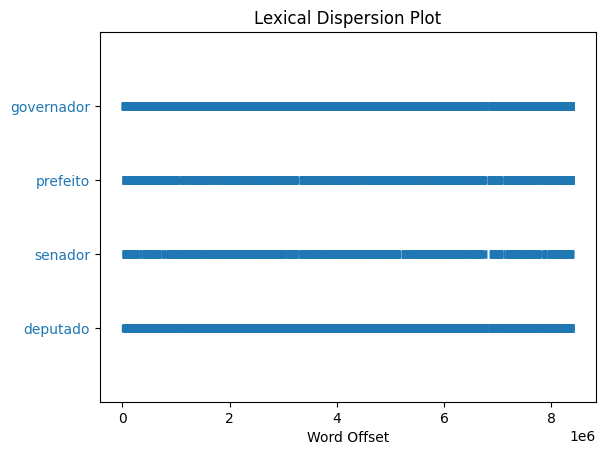

In [30]:
tc.dispersion_plot(['deputado', 'senador', 'prefeito', 'governador'])

# Separando frases
Além de quebrar os textos em seus tokens constituintes, podemos também dividi-los por frases, o que pode ser mais convenientes para certas análises. Para isso utilizamos a função `sent_tokenize` do nltk.

In [31]:
nltk.tokenize.sent_tokenize(biograficos.corpo[0])

['\n\n«Floriano Lopes Rubim» nasceu em Alegre (ES) no dia 18 de janeiro de\n1912, filho de Francisco Lopes Rubim, funcionário público, e de Maria\nSílvia Lousada Rubim.',
 'Bacharel em ciências jurídicas e sociais pela Faculdade de Direito da\nUniversidade do Espírito Santo, formou-se também na Escola de Educação\nFísica do Rio de Janeiro, então Distrito Federal, em 1941.',
 'Nesse mesmo\nano ingressou na Força Policial do Espírito Santo, onde faria carreira.',
 'Participou da campanha militar brasileira na Itália durante a Segunda\nGuerra Mundial (1939-1945), retornando ao Brasil em 1945, ao término do\nconflito.',
 'Em 1946 assumiu a direção da Penitenciária do Estado do Espírito Santo,\nque ocupou até o ano seguinte.',
 'Em 1948 passou a ajudante-de-ordens na\nCasa Militar do governador do Espírito Santo, Carlos Lindenberg\n(1947-1951), função que exerceu até 1949.',
 'Em outubro de 1950 elegeu-se\ndeputado estadual pelo Espírito Santo, na legenda do Partido Trabalhista\nBrasileiro 

# Busca textual
Realizar uma busca textual em uma coleção de textos é muito mais eficiente do que simplesmente realizar operações sobre coleções de strings. Neste capítulo iremos examinar como "indexar" o DHBB, usando um simples indexador/buscador chamado [whoosh](https://whoosh.readthedocs.io). 

In [33]:
from whoosh import index 
import os
from whoosh.fields import *
from IPython.core.display import display, HTML

In [34]:
schema = Schema(title=TEXT(stored=True), sexo=ID(stored=True), caminho=ID(stored=True), corpo=TEXT(stored=True))

In [35]:
if not os.path.exists('indexdir'):
    os.mkdir('indexdir')
    ix = index.create_in("indexdir", schema)
else:
    # ix = index.open_dir('indexdir') # se quiser adicionar novos documentos ao índice
    ix = index.create_in("indexdir", schema) # se Quiser começar do zero

In [36]:
writer = ix.writer()

In [37]:
for v in biograficos.itertuples():
    if pd.isnull(v.sexo):
        writer.add_document(title=v.title,sexo='na', caminho=v.arquivo,corpo=v.corpo)
    else:
        writer.add_document(title=v.title,sexo=v.sexo, caminho=v.arquivo,corpo=v.corpo)
writer.commit()

In [38]:
from whoosh.qparser import QueryParser
from whoosh import qparser

In [39]:
def busca(consulta):
    qp = QueryParser("corpo", ix.schema)
    qp.add_plugin(qparser.EveryPlugin())
    query = qp.parse(consulta)
    
    with ix.searcher() as searcher:
        results = [(dict(hit),hit.highlights("corpo")) for hit in searcher.search(query, limit=10)]
    return results
    

In [40]:
resultados = busca('assassin*')


In [41]:
print('Resultados:', len(resultados))
for res in resultados[:10]:
    print(res[0]['title'])
    display(HTML(res[1]))
   # encontra_pais(nltk.Text(nltk.tokenize.wordpunct_tokenize(res[0]['corpo'])))

Resultados: 10
PASCOAL, Hildebrando


RIPPOL, Valdemar


CUNHA, Francisco Flores da


MENDES, Chico


CUNHA NETO, Augusto


VAZ, Rubens


FURTADO, Heitor Alencar


VANNUCHI, Paulo


CUNHA, Ceci


BARROS, Manuel Gomes de
